# **MARKET BASKET ANALYSIS ON IMBD DATASET**
## Algorithms for Massive Datasets Project

In this project we will implement A-priori and FP-growth algorithms to in order to find frequent itemsets. In this case, we used the kaggle [IMDB Dataset](https://www.kaggle.com/ashirwadsangwan/imdb-dataset), in which we considered movies as baskets and actors as items.

----

Summary:

1.   Imports
2.   Pre-Processing
3.   Market Basket Analysis





## **1. Imports**

Importing kaggle.

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"martinaviggiano","key":"53a50dae23b35b3c81b9063b6c417e93"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing imdb-dataset data.

In [5]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

 99% 1.43G/1.44G [00:13<00:00, 118MB/s]
100% 1.44G/1.44G [00:13<00:00, 112MB/s]


In [6]:
!unzip imdb-dataset.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


## **2. Pre-processing**

We will consider movies as baskets and actors as items.


In [7]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 198 kB 35.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=323f8d22ddf23add96fefafa1a999fd8cc8cc86851488581686d7194862f9f92
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [8]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import pandas as pd
import pickle

In [9]:
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [10]:
title_basics = spark.read.csv('title.basics.tsv.gz', header=True, sep = '\t')

In [11]:
title_basics = title_basics.filter((title_basics.titleType == 'movie'))
title_basics.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|     \N|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|Soldiers of the C...|      0|     1900|     \N|            \N|     Biography,Drama|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|     \N|            70|Biography,Crim

In [12]:
title_basics_fraction = title_basics.sample(fraction=0.1, withReplacement=False, seed = 24)

In [13]:
title_principals = spark.read.csv('title.principals.tsv.gz', header=True, sep = '\t')

In [14]:
title_principals = title_principals.filter((title_principals.category == "actor") | (title_principals.category == "actress"))
title_principals = title_principals.select("tconst","nconst")
title_principals.show(5)

+---------+---------+
|   tconst|   nconst|
+---------+---------+
|tt0000005|nm0443482|
|tt0000005|nm0653042|
|tt0000007|nm0179163|
|tt0000007|nm0183947|
|tt0000008|nm0653028|
+---------+---------+
only showing top 5 rows



In [15]:
df_title = title_principals.join(title_basics, ["tconst"], 'leftsemi')
df_title_fraction = title_principals.join(title_basics_fraction, ["tconst"], 'leftsemi')
df_title.show(5)

+---------+---------+
|   tconst|   nconst|
+---------+---------+
|tt0000335|nm1010955|
|tt0000335|nm1012612|
|tt0000335|nm1011210|
|tt0000335|nm1012621|
|tt0000335|nm0675239|
+---------+---------+
only showing top 5 rows



In [16]:
name_basics = spark.read.csv('name.basics.tsv.gz', header=True, sep = '\t')

In [17]:
# Number of rows (movies) in the entire dataset
df_title.count()

1694722

In [18]:
# Number of rows (movies) in the dataset fraction 0.1
df_title_fraction.count()  

168642

## **3. Market Basket Analysis**

We define and populate baskets: for each movie (*tconst*) we assign the list of actors (*nconst*) preforming in it.

In [19]:
from pyspark.sql.functions import collect_set, col, count, avg
from pyspark.ml.fpm import FPGrowth
import pandas as pd
import time
from tqdm import tqdm

In [20]:
# Computed on the whole df
baskets = df_title.groupBy('tconst').agg(collect_set('nconst').alias('actors'))
baskets.createOrReplaceTempView('baskets')
baskets.show(5)

+---------+--------------------+
|   tconst|              actors|
+---------+--------------------+
|tt0000335|[nm1012612, nm067...|
|tt0000630|         [nm0624446]|
|tt0000676|[nm0140054, nm009...|
|tt0000793|         [nm0691995]|
|tt0000862|[nm0264569, nm528...|
+---------+--------------------+
only showing top 5 rows



In [21]:
# Computed on 0.1 fraction
baskets_fraction = df_title_fraction.groupBy('tconst').agg(collect_set('nconst').alias('actors'))
baskets_fraction.createOrReplaceTempView('baskets_fraction')
baskets_fraction.show(5)

+---------+--------------------+
|   tconst|              actors|
+---------+--------------------+
|tt0000630|         [nm0624446]|
|tt0001112|[nm0135493, nm014...|
|tt0001370|[nm0105501, nm089...|
|tt0001381|[nm2547818, nm052...|
|tt0001569|         [nm0681933]|
+---------+--------------------+
only showing top 5 rows



### **3.1 FP-Growth**
In this section we will implement the FP-Growth algorithm by using the *FPGrowth* function of Spark.

First we will run it using different values of support to see the differences in terms of time spent in computation and average confidence.

In [22]:
# 5 values of support with respect to time spent in computation
seconds = []
confidences = []
n_rules = []
supports = [0.00001, 0.00002, 0.00003, 0.00004, 0.0001]

for sup in tqdm(supports):
    fpGrowth = FPGrowth(itemsCol="actors", minSupport=sup)
    start_time = time.time()
    model_ = fpGrowth.fit(baskets)
    seconds.append([sup, time.time() - start_time])
    associationRules_ = model_.associationRules
    rules = associationRules_.count()
    n_rules.append([sup, rules])
    conf = associationRules_.select(avg(col("confidence"))).first()[0]
    confidences.append([sup, conf])

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning
100%|██████████| 5/5 [14:59<00:00, 179.90s/it]


In [23]:
# Display the association rules of the model with the last value of support
associationRules = model_.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.show(10)

+--------------------+-----------+------------------+------------------+--------------------+
|          antecedent| consequent|        confidence|              lift|             support|
+--------------------+-----------+------------------+------------------+--------------------+
|[nm2394215, nm029...|[nm0945427]|0.8055555555555556|1455.0217889908256|1.472982204851190...|
|[nm1283907, nm064...|[nm2373718]|0.8909090909090909| 2740.652130681818|1.244416000650144E-4|
|[nm1283907, nm064...|[nm2082516]|0.9272727272727272|2267.8383963862225|1.295208490472598...|
|[nm2373151, nm208...|[nm2077739]|0.8181818181818182|2753.5594405594406|1.142831021005234...|
|[nm2373151, nm208...|[nm2373718]|0.8727272727272727|2684.7204545454547|1.219019755738916...|
|[nm2373151, nm208...|[nm0648803]|               1.0| 696.9185840707964|1.396793470117508...|
|[nm1283907, nm237...|[nm0648803]|               1.0| 696.9185840707964|1.168227265916461...|
|[nm2077739, nm064...|[nm2373718]|0.8407079646017699|2586.22

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


We plot the relation between value of support and time spent in computing.

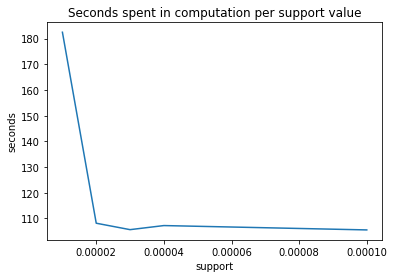

In [24]:
df_results = pd.DataFrame(seconds, columns=["support", "seconds"])
df_results.plot(x="support", y="seconds", ylabel='seconds',legend=False, title='Seconds spent in computation per support value')
df_results.to_csv("time_results_fpgrowth.csv", index=False)

In [25]:
df_results

,support,seconds
0,0.00001,182.493003
1,0.00002,108.157942
2,0.00003,105.652658
3,0.00004,107.241933
4,0.00010,105.548992


In [26]:
!cp time_results_fpgrowth.csv /content/drive/MyDrive/Università/amd_Market_Basket/

We plot the relation between value of support and average value of confidence retrieved.

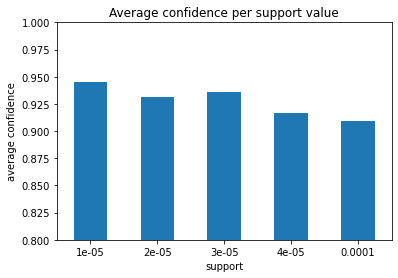

In [51]:
## DEVO ESPANDERE NOTAZIONE SCIENTIFICA
df_avgconf = pd.DataFrame(confidences, columns=["support", "average_confidence"])
df_avgconf.plot.bar(x="support", y="average_confidence", ylabel='average confidence', legend=False, title='Average confidence per support value', ylim=(0.8,1), rot=0)
df_avgconf.to_csv("avgconficence_results_fpgrowth.csv", index=False)

In [28]:
df_avgconf

,support,average_confidence
0,0.00001,0.945333
1,0.00002,0.931293
2,0.00003,0.936198
3,0.00004,0.916267
4,0.00010,0.909584


In [29]:
!cp avgconficence_results_fpgrowth.csv /content/drive/MyDrive/Università/amd_Market_Basket/

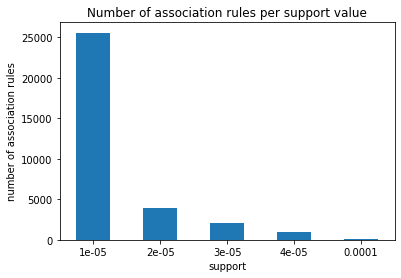

In [30]:
df_nrules = pd.DataFrame(n_rules, columns=["support", "n_rules"])
df_nrules.plot.bar(x="support", y="n_rules", ylabel='number of association rules', legend=False, title='Number of association rules per support value', rot=0)
df_nrules.to_csv("nrules_results_fpgrowth.csv", index=False)

In [31]:
df_nrules

,support,n_rules
0,0.00001,25583
1,0.00002,3893
2,0.00003,2051
3,0.00004,940
4,0.00010,120


In [32]:
!cp nrules_results_fpgrowth.csv /content/drive/MyDrive/Università/amd_Market_Basket/

In the following part we will select one support value (INSERT HERE) to use and we will display the results of the model.

In [33]:
fpGrowth = FPGrowth(itemsCol="actors", minSupport=0.00001)
model = fpGrowth.fit(baskets)

In [34]:
# Display generated association rules of the model computed setting the support equal to 0.00001
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+-----------+------------------+------------------+--------------------+
|          antecedent| consequent|        confidence|              lift|             support|
+--------------------+-----------+------------------+------------------+--------------------+
|         [nm3721804]|[nm1990182]|               0.8|3841.5512195121955|1.015849796449097E-5|
|         [nm3721804]|[nm1984183]|               1.0|2250.0514285714285|1.269812245561371...|
|[nm0623325, nm381...|[nm0706691]|0.8571428571428571|1071.4530612244896|1.523774694673645...|
|[nm2719915, nm128...|[nm1770187]|0.8571428571428571|2836.1992797118846|1.523774694673645...|
|[nm2719915, nm128...|[nm2077739]|0.8571428571428571|2884.6813186813188|1.523774694673645...|
|[nm2719915, nm128...|[nm0648803]|               1.0| 696.9185840707964| 1.77773714378592E-5|
|[nm1371510, nm075...|[nm1285427]|               0.8|3461.6175824175825|1.015849796449097E-5|
|[nm0931054, nm041...|[nm0001889]|               0.8|       

In [35]:
associationRules.select(avg(col("confidence"))).show()

+------------------+
|   avg(confidence)|
+------------------+
|0.9453328386316634|
+------------------+



In [36]:
associationRules.count()

25583

In [37]:
# Frequent itemsets and query
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")

query = """select items, freq
           from mostPopularItemInABasket
           where size(items) > 5
           order by freq desc
           limit 10"""
spark.sql(query).show(10)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+----+
|               items|freq|
+--------------------+----+
|[nm2687024, nm237...|  20|
|[nm2426685, nm207...|  17|
|[nm2373151, nm236...|  17|
|[nm2414317, nm207...|  16|
|[nm0455938, nm268...|  15|
|[nm2373151, nm207...|  15|
|[nm2811639, nm677...|  14|
|[nm2681040, nm144...|  14|
|[nm1283907, nm237...|  14|
|[nm2846621, nm405...|  14|
+--------------------+----+



In [38]:
query = """select antecedent as `antecedent`, consequent as `consequent`, confidence
           from associationRules
           order by confidence desc
           limit 10"""

spark.sql(query).show(10)

+--------------------+-----------+----------+
|          antecedent| consequent|confidence|
+--------------------+-----------+----------+
|[nm2679281, nm029...|[nm0945427]|       1.0|
|[nm7096417, nm040...|[nm2366585]|       1.0|
|[nm1039432, nm005...|[nm0042874]|       1.0|
|[nm1039432, nm005...|[nm0781958]|       1.0|
|[nm2719915, nm128...|[nm0648803]|       1.0|
|[nm1039432, nm030...|[nm0058601]|       1.0|
|         [nm3721804]|[nm1984183]|       1.0|
|[nm1039432, nm030...|[nm0042874]|       1.0|
|[nm0667024, nm037...|[nm0327762]|       1.0|
|[nm1039432, nm030...|[nm0781958]|       1.0|
+--------------------+-----------+----------+



In case we wanted to displey the actual name of the actor/actress instead of the ID, we can run the following cells.

In [39]:
name_basics = name_basics.select("nconst","primaryName")

In [40]:
df_actors_names = df_title.join(name_basics, ["nconst"], 'left')

In [42]:
df_actors_names = df_actors_names.select("tconst","primaryName")

In [44]:
baskets_names = df_actors_names.groupBy('tconst').agg(collect_set('primaryName').alias('actors'))
baskets_names.createOrReplaceTempView('baskets_')
df_actors_names.show(5)
baskets_names.show(5)

+---------+-----------------+
|   tconst|      primaryName|
+---------+-----------------+
|tt0000009|  Blanche Bayliss|
|tt0000502|      El Mochuelo|
|tt0000615|       Jim Gerald|
|tt0000679|    L. Frank Baum|
|tt0000009|William Courtenay|
+---------+-----------------+
only showing top 5 rows

+---------+--------------------+
|   tconst|              actors|
+---------+--------------------+
|tt0000335|[John Jones, Mr. ...|
|tt0000502|[Antonio del Pozo...|
|tt0000630|[Fernanda Negri P...|
|tt0000676|[Jaime Borrás, Jo...|
|tt0000793|      [Henny Porten]|
+---------+--------------------+
only showing top 5 rows



---

### **3.2 A-priori Algorithm**
We implement an A-priori Algorithm from scratch.

! SPIEGARE PASSAGGI !

The function takes as input a Resilient Distributed Dataset (RDD) and a threshold.

In [45]:
conf = SparkConf().setAppName("MBA")
spark = SparkSession.builder.enableHiveSupport().config(conf = conf).getOrCreate()
sc = spark.sparkContext

In [46]:
import itertools
from itertools import combinations, product
import pandas as pd
import matplotlib.pyplot as plt
import collections
import time
import pickle

First of all, we create a list of baskets of actors and then we parallelize the list in RDD.

In [47]:
# Computed on the whole dataset
baskets_actors = baskets.select('actors').rdd.flatMap(list) 
print(baskets_actors.collect()[:3])

[['nm1012612', 'nm0675260', 'nm1012621', 'nm1010955', 'nm0675239', 'nm1011210'], ['nm0624446'], ['nm0140054', 'nm0097421']]


In [48]:
baskets_actors.getNumPartitions() 

4

In [ ]:
# Computed on the fraction 0.1
baskets_actors_fraction = baskets_fraction.select('actors').rdd.flatMap(list) 
print(baskets_actors_fraction.collect()[:3])

[['nm0624446'], ['nm0135493', 'nm0143332'], ['nm0105501', 'nm0896618', 'nm0764002']]


In [ ]:
baskets_actors_fraction.getNumPartitions() 

2

### Provo a scrivere nuove funzioni

 We first define a function listing all the actors/actresses present in dataset and counting occurrences.

In [49]:
def count_singletons(data): 
  list_singletons = data.flatMap(list).map(lambda actor: (actor, 1)).reduceByKey(lambda a, b: a+b)
  return(list_singletons)

We display the top 10 actors present in our dataset with respect to the occurrencies.

In [50]:
freq_actors = count_singletons(baskets_actors).sortBy(lambda a: -a[1])
freq_actors.take(10)

[('nm0103977', 797),
 ('nm0006982', 585),
 ('nm0648803', 565),
 ('nm0305182', 506),
 ('nm0623427', 436),
 ('nm0793813', 411),
 ('nm0246703', 391),
 ('nm0619107', 387),
 ('nm0007123', 380),
 ('nm7390393', 356)]

In [ ]:
# check what "list(combinations...)" does.
possible_combinations = list(combinations(freq_actors_threshold.toLocalIterator(),2)) 

In [ ]:
possible_combinations

[('nm0103977', 'nm0006982'),
 ('nm0103977', 'nm0648803'),
 ('nm0103977', 'nm0305182'),
 ('nm0103977', 'nm0623427'),
 ('nm0103977', 'nm0793813'),
 ('nm0103977', 'nm0246703'),
 ('nm0103977', 'nm0619107'),
 ('nm0103977', 'nm0007123'),
 ('nm0103977', 'nm7390393'),
 ('nm0103977', 'nm0046850'),
 ('nm0103977', 'nm0482320'),
 ('nm0103977', 'nm0149822'),
 ('nm0103977', 'nm0304262'),
 ('nm0103977', 'nm0706691'),
 ('nm0103977', 'nm0619309'),
 ('nm0103977', 'nm0007106'),
 ('nm0103977', 'nm0659250'),
 ('nm0103977', 'nm0419653'),
 ('nm0103977', 'nm0001000'),
 ('nm0103977', 'nm0415549'),
 ('nm0103977', 'nm0000465'),
 ('nm0103977', 'nm0035067'),
 ('nm0103977', 'nm0261738'),
 ('nm0103977', 'nm0534867'),
 ('nm0103977', 'nm0004417'),
 ('nm0103977', 'nm0374974'),
 ('nm0103977', 'nm0006369'),
 ('nm0103977', 'nm0222432'),
 ('nm0103977', 'nm1894124'),
 ('nm0103977', 'nm0004429'),
 ('nm0103977', 'nm0023173'),
 ('nm0103977', 'nm1352627'),
 ('nm0103977', 'nm3183374'),
 ('nm0103977', 'nm0347953'),
 ('nm0103977',

We then define a function filtering out singletons (actors) not compliant with the threshold we chose.

In [ ]:
def actors_threshold(baskets, threshold, remove=True):
    actors_selected = count_singletons(baskets).filter(lambda freq: freq[-1] >= threshold)
    if removed:
        actors_selected = actors_selected.map(lambda a: (a[:-1])) #(a[0])
    return (actors_selected)

In [ ]:
# Testing 
t1 = actors_threshold(baskets_actors, 118)

In [ ]:
t1.take(2)

['nm0435229', 'nm0002503']

We define a function which performs the computations of both the functions above: *count_singletons* and *actors_threshold*.

In [42]:
def singleton_threshold(data, threshold):
    list_singletons = data.flatMap(list).map(lambda actor: (actor, 1)).reduceByKey(lambda a, b: a+b)
    actors_counts = list_singletons.filter(lambda freq: freq[1] >= threshold)
    actors_selected = actors_counts.map(lambda a: (a[0])) #(a[0])
    return(actors_selected)

In [43]:
# Testing
t2 = singleton_threshold(baskets_actors, 118)

In [ ]:
t2.take(2)

['nm0435229', 'nm0002503']

Two different versions of a-priori algorithm to follow.

In [ ]:
# MOLTO SIMILE a quello originale:
#   cambiati nomi variabili
#   inserito "singletons" tra variabili input, al posto di generarli all'interno di questa funzione con count_singletons

def priori(baskets, singletons, threshold):
    comb_actors = list(combinations(singletons.toLocalIterator(),2)) 
    #initialize support as empty rdd
    selected = sc.parallelize([]) 
    #cache the rdd for better perfomance, it is reused multiple times
    baskets.cache()
    i=3 #starts at 3 since we already found the pairs
    #cicles until possible combinations are found
    while len(comb_actors)>0: 
        #chek whether the possible items are frequent in the dataset
        frequent_items = baskets.flatMap(lambda basket: [(tuple(item), 1) for item in comb_actors if set(list(item)).issubset(set(basket))])
        frequent_items_1 = frequent_items.reduceByKey(lambda x, y: x+y).filter(lambda item: item[1] >= threshold)
        #add the frequent items and their occurrencies to support rdd
        selected = selected.union(frequent_items) 
        #generates new items from the last frequent items found using the function defined above
        comb_actors = new_combinations(frequent_items, i) 
        #increment i
        i += 1  
        
    #remove actor_baskets from cache
    baskets.unpersist()
    return(selected)

In [44]:
# Parte da una base modificata (come funzione precedente con cambio variabili + singleton)
# L'idea teorica alla base è la seguente: 
#   se il singolo attore A non è frequente (in base al threshold X scelto), la combinazione (coppia) tra attore A e attore B non può essere frequente
#   Questo concetto vale anche per combinazioni di 3, 4, 5 attori.
# L'obiettivo è quello di:
#   - per ogni set di combinazioni ottenute da "list(combinations(singletons.toLocalIterator(), number))" - cioè per ogni "number", ossia set di coppie, triplette ecc -
#     la funzione considera solo le combinazioni composte da singletons (items, ossia attori) che abbiano frequenza superiore al threshold.
#   - Per fare ciò, forniamo "singletons" come input, ossia abbiamo già calcolato prima gli items (attori) che rispettano il threshold, con "actors_threshold()".
#   - Le coppie procedono solo se entrambi gli items sono nella lista restituita da "actors_threshold()" (cioè input "singletons").
#   - Iterando nelle combinazioni successive (triplette, quadriplette...), la funzione parte dalle combinazioni di dimensione "number-1"
#     (esempio: per le triplette dove number=3, la funzione considera le doppiette) già presenti nelle lista "selected" e aggiunge un item singolo (attore) dalla lista
#     di singletons fornita in input ("singletons").
#   - Per ognuna di queste nuove combinazioni, la funzione filtra per il threshold scelto: procedono solo combinazioni che hanno frequenza superiore al threshold.
 


# La prima funzione prende i singleton che rispettano in threshold e crea combinazioni usando essi.
# Infine testa se questi pairs hanno frequenza superiore al threshold: se si, restituisce i pairs in "selected_pairs".

def new_priori_1(baskets, singletons, threshold):

    #comb_actors = list(combinations(singletons.toLocalIterator(), number)) 
    comb_actors = list(combinations(singletons.toLocalIterator(), 2))
    selected = sc.parallelize([]) 
    baskets.cache()
    #i=3 #more than pairs
    
    frequent_items = baskets.flatMap(lambda basket: [(tuple(item), 1) for item in comb_actors if set(list(item)).issubset(set(basket))]).reduceByKey(lambda a, b: a+b).filter(lambda freq: freq[1] >= threshold)
        
    selected_pairs = selected.union(frequent_items) 
    #generates new items from the last frequent items found using the function defined above
    #comb_actors = new_combinations(frequent_items, i) 
    #increment i
    #i += 1  
    #number += 1
        
    #remove actor_baskets from cache
    baskets.unpersist()
    return(selected_pairs)

# Con questa funzione si vuole calcolare le triplette.
# Partendo dai pairs calcolati nella funzione precedente, si calcolano tutte le possibili combinazioni tra i pairs ottenuti prima e i singletons ottenuti precedentemente (cioè 
# gli attori con frequenza superiore al threshold ottenuti con "actors_threshold()"). <- COME FARE????

def new_priori_2(baskets, singletons, pairs, threshold):

    # Opzione 1
    #comb_actors = list(combinations(singletons.toLocalIterator(), 3)) # Non va bene perchè partirebbe da zero, senza considerare i risultati precedenti
    
    # Opzione 2
    comb_actors = list(itertools.product(pairs, singletons)) # Può funzionare??

    # Opzione 3
    # Fare come in funzione new_combinations al aprtire da "for comb in list(product...", cioè il catesian product, ma non so se funzioni.

    selected = sc.parallelize([]) 
    baskets.cache()
    #i=3 #more than pairs
    
    frequent_items = baskets.flatMap(lambda basket: [(tuple(item), 1) for item in comb_actors if set(list(item)).issubset(set(basket))]).reduceByKey(lambda a, b: a+b).filter(lambda freq: freq[1] >= threshold)
        
    selected_triplets = selected.union(frequent_items) 
    #generates new items from the last frequent items found using the function defined above
    #comb_actors = new_combinations(frequent_items, i) 
    #increment i
    #i += 1  
    #number += 1
        
    #remove actor_baskets from cache
    baskets.unpersist()
    return(selected_triplets)

---

### Funziona

In [ ]:
def count_singletons(data): 
  list_singletons = data.flatMap(list).map(lambda actor: (actor, 1)).reduceByKey(lambda a, b: a+b)
  return(list_singletons)

In [ ]:
def new_combinations(items, i):
  #removes the counter
  items = items.map(lambda item: list(item[0])) 
  #generate singletons from each item in items
  singleton = count_singletons(items).map(lambda item: [item[0]]) 
  #initialize an empty list that will contain the new possible combinations
  items_set = [] 
  #for cicle generates the new combinations using the carthesian product between 
  #items and singletons. the result will be like [[item],[singleton]]
  for comb in list(product(items.toLocalIterator(), singleton.toLocalIterator())): 
    #merges the two lists into a "new item" with form "new item"=[item, singleton]
    comb = comb[0]+comb[1] 
    #takes the set of each combination and orders it to prevent permutations to
    #be counted as different item and to remove the repetitions of actors
    comb_set = sorted(set().union(comb))
    #if the set have size == i and was not already included in items_set
    #then it is added to items_set
    if (len(comb_set) == i) and comb_set not in items_set: 
        items_set.append(comb_set) #popoliamo items_set
  return(items_set)

In [ ]:
def apriori(baskets, threshold): 
  #generate singletons 
  singleton = count_singletons(baskets).filter(lambda freq: freq[1] >= threshold).map(lambda x: (x[0])) 
  #find the possible pairs            
  comb_actors = list(combinations(singleton.toLocalIterator(),2)) 
  #initialize support as empty rdd
  support_set = sc.parallelize([]) 
  #cache the rdd for better perfomance, it is reused multiple times
  baskets.cache()
  n=3 #starts at 3 since we already found the pairs
  #cicles until possible combinations are found
  while len(comb_actors)>0: 
    #chek whether the possible items are frequent in the dataset
    frequent_items = baskets.flatMap(lambda basket: [(tuple(item), 1) for item in comb_actors if set(list(item)).issubset(set(basket))]) \
                    .reduceByKey(lambda a, b: a+b).filter(lambda freq: freq[1] >= threshold)
    #add the frequent items and their occurrencies to support rdd
    support_set = support_set.union(frequent_items) 
    #generates new items from the last frequent items found using the function defined above
    comb_actors = new_combinations(frequent_items, n) 
    #increment i
    n += 1  
    
  #remove actor_baskets from cache
  baskets.unpersist()
  return (support_set)

We set the threshold value for considering baskets of actors and actresses at various levels.

In [ ]:
#compute the Minimum Support using 0.0001 as fraction of the number of baskets
#in order for pairs, triple etc. to be considered frequent 
count = baskets_actors.count()
threshold = count*0.00025
print(count, threshold)

393759 98.43975


In [ ]:
# Fraction 0.1
count_fraction = baskets_actors_fraction.count()
threshold_fraction = count*0.0003
print(count_fraction, threshold_fraction)

39228 39.228


In [ ]:
#Output of A-Priori on all baskets with 118 as minimum support
print(apriori(baskets_actors, threshold).collect()) # 6h 10

[(('nm0006982', 'nm0623427'), 236), (('nm0006982', 'nm0419653'), 162), (('nm0006982', 'nm0046850'), 169), (('nm0648803', 'nm2373718'), 126), (('nm0006982', 'nm0619779'), 122), (('nm2082516', 'nm0648803'), 147)]


In [ ]:
# Whole dataset ca 6h 10min
start_time = time.time()
list_apriori = apriori(baskets_actors, threshold).collect() 
print(time.time() - start_time)

In [ ]:
list_apriori # total 0.0001 

In [ ]:
list_apriori # total 0.00025  

In [ ]:
list_apriori # total 0.0003 6h 10 min

[(('nm0006982', 'nm0623427'), 236),
 (('nm0006982', 'nm0419653'), 162),
 (('nm0006982', 'nm0046850'), 169),
 (('nm0648803', 'nm2373718'), 126),
 (('nm0006982', 'nm0619779'), 122),
 (('nm2082516', 'nm0648803'), 147)]

In [ ]:
list_apriori #0.0004 #1h 10min

[(('nm0006982', 'nm0623427'), 236),
 (('nm0006982', 'nm0419653'), 162),
 (('nm0006982', 'nm0046850'), 169)]

In [ ]:
list_apriori # total 0.0005 15min?

[(('nm0006982', 'nm0623427'), 236)]

In [ ]:
# Fraction  0.1 = 1h 17min
start_time = time.time()
list_apriori = apriori(baskets_actors, threshold).collect() 
print(time.time() - start_time)

In [ ]:
with open("/content/drive/MyDrive/Università/amd_Market_Basket/list_apriori_00025.pkl", "wb") as f:
    pickle.dump(list_apriori, f)

Load back the list.

In [ ]:
with open("/content/drive/MyDrive/Università/amd_Market_Basket/list_apriori.pkl", "rb") as f:
    list_apriori = pickle.load(f)

In [ ]:
list_apriori_10

[(('nm0619779', 'nm0006982'), 16),
 (('nm0619779', 'nm0623427'), 15),
 (('nm0006982', 'nm0623427'), 30),
 (('nm0006982', 'nm0046850'), 21),
 (('nm0006982', 'nm0419653'), 19),
 (('nm0046850', 'nm0419653'), 16),
 (('nm0623427', 'nm0419653'), 14),
 (('nm0616102', 'nm0006982'), 13),
 (('nm2366585', 'nm2384746'), 12),
 (('nm2082516', 'nm0648803'), 15),
 (('nm0006982', 'nm0619779', 'nm0623427'), 12)]

---

Altre possibilità.

In [ ]:
uniqueItems = wlitems.distinct()

# Add 1 as Tuple
supportRdd = wlitems.map(lambda item: (item , 1))

# Method for sum in reduceByKey method
def sumOparator(x,y):
    return x+y

# Sum of values by key
supportRdd = supportRdd.reduceByKey(sumOparator)

# print(supportRdd.collect()) # Retruns following array 
# [('Apple', 12), ('Mango', 10), ('Banana', 9), ('Coconut', 3), 
#  ('Strawberry', 4), ('Grapes', 2), ('Lemon', 1), ('Raspberry', 9), ('Rassberry', 1)]


# First support values
supports = supportRdd.map(lambda item: item[1]) # Return only support values

KeyboardInterrupt: ignored

In [ ]:
c = 2 # Combination length 

while(supportRdd.isEmpty() == False):

    combined = supportRdd.cartesian(uniqueItems)
    combined = combined.map(lambda item: removeReplica(item))
  
    combined = combined.filter(lambda item: len(item) == c)
    combined = combined.distinct()

    
    combined_2 = combined.cartesian(lblitems)
    combined_2 = combined_2.filter(lambda item: all(x in item[1] for x in item[0]))
    
    combined_2 = combined_2.map(lambda item: item[0])
    combined_2 = combined_2.map(lambda item: (item , 1))
    combined_2 = combined_2.reduceByKey(sumOparator)
    combined_2 = combined_2.filter(lambda item: item[1] >= minSupport)

    baseRdd = baseRdd.union(combined_2)
    
    combined_2 = combined_2.map(lambda item: item[0])
    supportRdd = combined_2
    print(c ,'. Table has crated... ')
    c = c+1 

In [ ]:
def apriori(rdd, threshold):
  
  singleton = rdd.flatMap(list).map(lambda item: (item , 1)).reduceByKey(lambda actor1, actor2: actor1+actor2).filter(lambda item: item[1] >= threshold ) 

  freq_act = singleton.map(lambda item : (item[0])) # all the pair of frequent items 

  pairs_of_freq_act = list(itertools.combinations(freq_act.toLocalIterator(),2)) # finding all the possible pairs
  
  table_of_pairs = rdd.flatMap(lambda x : [(tuple(item), 1) for item in pairs_of_freq_act if set(list(item)).issubset(set(x))]).cache() \
                  .reduceByKey(lambda actor1, actor2: actor1+actor2) \
                  .filter(lambda item: item[1] >= threshold)

  return (table_of_pairs)

In [ ]:
from pyspark.sql import SQLContext
import itertools
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
startTime = time.time()
apriori(baskets_actors_fraction, threshold_fraction )
APrioriTime = time.time()-startTime

In [ ]:
APrioriTime

3.576289415359497

In [ ]:
AprioriResults = apriori(baskets_actors_fraction, threshold_fraction)
result = sqlContext.createDataFrame(AprioriResults).toDF("Pairs of actors and actresses", "Number of movies")
result.show()

KeyboardInterrupt: ignored